In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement, combinations
import libpysal.weights as lpw

In [193]:
# set seed
seed_value = 42
np.random.seed(seed_value)

In [194]:
# coordinates function
def make_coords(N_points, xm, xM, ym, yM):
    
    # Define the range of coordinate values
    xmin, ymin = xm, ym
    xmax, ymax = xM, yM
    
    x_coords = np.random.uniform(xmin, xmax, size=N_points)
    y_coords = np.random.uniform(ymin, ymax, size=N_points)
    coords = np.column_stack((x_coords, y_coords))
    return coords
    

In [195]:
# make coordinates
N = 20
coords = make_coords(N, 0, 10, 0, 10)

In [196]:
# calculate inverse matrix A
# function that makes weight matrix
def make_weight(coords, thres):
    w = lpw.DistanceBand.from_array(coords, threshold=thres, binary=True)
    w.transform = 'R'
    return w.full()[0]


# function that checks if the matrix is invertible
def check_invertible(matrix):
    try:
        inverse = np.linalg.inv(matrix)
        return inverse
    except np.linalg.LinAlgError:
        return False

    
# function that calculates A
def get_A(coords, N, thres, rho):
    
    # make weight matrix
    W = make_weight(coords, thres)
    
    # calculate (I - rho * W)
    I = np.identity(N)
    X = I - rho * W
    
    # get A
    A = check_invertible(X)
    
    return A

In [197]:
# simulation
# set up parameters
n = 1000
threshold = 5
rho = 0.5 

# calculate invertible matrix A
A = get_A(coords, N, threshold, rho)

results = [] # generated n * y = [y1, y2, ..., yN]
V = [] # randomly generated v = [v1, v2, ..., vD], (D = N)

# run simulations
for i in range(n):
    # Generate random v from standard normal distribution
    v = np.random.randn(N, 1) 
    V.append(v)
    # Compute the matrix product
    y = np.dot(A, v) # y = N x 1 vector
    results.append(y)
    
    # if i % 10 == 0:
    #     print(f"Iteration: {i+1} / {n}")
    #     print("The shape of the simulation result is: ", np.shape(results))


print("The shape of the simulation result is: ", np.shape(results)) # (n, N, 1), cf. 3D array

The shape of the simulation result is:  (1000, 20, 1)


In [198]:
# convert results into dataframe (n, N) 
# make a column names list; y1, y2, ..
col_names = []

for i in range(N):
    col_names.append('y{}'.format(i+1))

simul_df = pd.DataFrame(np.reshape(results, (n, N)), columns=col_names)

print(simul_df)

           y1        y2        y3        y4        y5        y6        y7   
0   -0.176288 -1.504306  0.481104 -1.462833 -0.041076 -2.024568 -1.640802  \
1   -0.439835  0.873265  1.254886  1.119476 -0.615585 -0.166956  0.361476   
2    0.014418  1.166561 -2.682814  0.644276  0.222437 -0.086963  0.365894   
3   -0.950054 -0.825683 -0.907350 -1.902917 -0.054202  0.042506 -0.152282   
4    0.090383  2.422114 -0.125786  0.348781  0.104855 -1.084625  1.284004   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.510051  0.901262  1.333514 -1.106363 -1.495458  2.175198 -0.108800   
996 -0.682179 -0.752077 -0.092792 -1.091957 -1.383892 -2.893773  1.302295   
997 -1.034458 -0.967970 -0.944507  0.677402 -0.781160 -1.318204  0.658460   
998  1.174818  1.169000  1.284296  0.781863  1.781559  0.654606  2.231683   
999 -0.450619 -0.983809  0.598200 -0.028223 -1.306345 -1.316398 -1.031751   

           y8        y9       y10       y11       y12       y13       y14  

In [199]:
# calculate covariance between yi & yj
# get variance of vector V 
var = np.var(V)

# initialize an empty covariance matrix
cov_model = np.zeros((N, N))


for i in range(N):
  for k in range(N):
    for j in range(N):
      cov_model[i,k] += A[i,j] * A[k,j]
      cov_model[k,i] += A[i,j] * A[k,j]

cov_model = var * cov_model / 2

# convert results to dataframe
cov_model = pd.DataFrame(cov_model, columns=col_names, index=col_names)
cov_model

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16,y17,y18,y19,y20
y1,1.161239,0.058540,0.172534,0.176426,0.227708,0.244870,0.110253,0.079837,0.219149,0.067431,0.234477,0.058540,0.058540,0.254101,0.261464,0.244870,0.200991,0.077964,0.227954,0.214662
y2,0.058540,1.194788,0.259832,0.252195,0.048624,0.029904,0.061822,0.285284,0.081934,0.302818,0.032279,0.319301,0.319301,0.024186,0.023208,0.029904,0.097390,0.271526,0.072363,0.076123
y3,0.172534,0.259832,1.163115,0.230399,0.092782,0.076805,0.091021,0.247953,0.197039,0.252792,0.076585,0.259832,0.259832,0.062170,0.062151,0.076805,0.201086,0.235421,0.178104,0.184233
y4,0.176426,0.252195,0.230399,1.160540,0.175084,0.085580,0.101417,0.241360,0.200077,0.245463,0.085269,0.252195,0.252195,0.072547,0.066048,0.085580,0.203231,0.229685,0.181056,0.187475
y5,0.227708,0.048624,0.092782,0.175084,1.162751,0.239840,0.252574,0.070033,0.218108,0.059415,0.241734,0.048624,0.048624,0.246168,0.142589,0.239840,0.212039,0.083683,0.220763,0.225657
y6,0.244870,0.029904,0.076805,0.085580,0.239840,1.173960,0.101746,0.057549,0.219401,0.034493,0.254082,0.029904,0.029904,0.281309,0.288090,0.271945,0.109354,0.049305,0.237279,0.217845
y7,0.110253,0.061822,0.091021,0.101417,0.252574,0.101746,1.163381,0.050517,0.098765,0.077081,0.256288,0.061822,0.061822,0.091389,0.077724,0.101746,0.261962,0.240961,0.107204,0.259090
y8,0.079837,0.285284,0.247953,0.241360,0.070033,0.057549,0.050517,1.172665,0.197705,0.270946,0.049082,0.285284,0.285284,0.046042,0.045816,0.057549,0.101729,0.141445,0.179818,0.085336
y9,0.219149,0.081934,0.197039,0.200077,0.218108,0.219401,0.098765,0.197705,1.147633,0.089448,0.123112,0.081934,0.081934,0.117353,0.111798,0.219401,0.206193,0.088964,0.220707,0.216832
y10,0.067431,0.302818,0.252792,0.245463,0.059415,0.034493,0.077081,0.270946,0.089448,1.185260,0.044229,0.302818,0.302818,0.028535,0.027168,0.034493,0.198010,0.266417,0.079585,0.084788


In [200]:
# distance matrix
# initialize an empty distances matrix
distances = np.zeros((N, N))

# compute the euclidean distance between pair of coords
for i in range(N):
    for j in range(i+1, N):
        distances[i,j] = distances[j,i] = np.linalg.norm(coords[i] - coords[j])    

# convert distances to dataframe
distances = pd.DataFrame(distances, columns=col_names, index=col_names)
distances

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16,y17,y18,y19,y20
y1,0.000000,7.450502,4.795692,3.324077,2.683653,2.789320,5.196502,5.012338,2.274072,6.564479,3.539818,7.411047,7.132085,3.740323,4.028633,2.741579,3.151788,5.356742,0.923808,1.908448
y2,7.450502,0.000000,2.667224,4.188226,8.554307,10.239555,8.946570,3.841578,5.721511,2.598694,10.412556,0.364876,1.397492,10.955879,11.285810,10.179372,6.672261,4.280060,7.522382,7.247871
y3,4.795692,2.667224,0.000000,1.525993,5.988481,7.581921,6.802250,2.594778,3.275535,2.468560,7.781907,2.671994,2.483167,8.374663,8.696385,7.533042,4.279334,2.841953,4.937233,4.649515
y4,3.324077,4.188226,1.525993,0.000000,4.516388,6.093904,5.656908,3.056665,2.260661,3.381047,6.263695,4.197380,3.813698,6.989825,7.299828,6.064909,3.008218,2.786677,3.589366,3.161611
y5,2.683653,8.554307,5.988481,4.516388,0.000000,3.291060,2.744636,7.125355,4.655111,6.874240,2.031921,8.625285,7.813097,4.960234,5.102151,3.533901,2.119180,5.142145,3.580415,1.361442
y6,2.789320,10.239555,7.581921,6.093904,3.291060,0.000000,5.936323,7.601100,4.850662,9.222286,2.233578,10.199289,9.880087,1.731345,1.822954,0.359241,5.029089,7.801582,2.938335,3.705801
y7,5.196502,8.946570,6.802250,5.656908,2.744636,5.936323,0.000000,8.671574,6.701704,6.678047,4.095913,9.122921,7.859739,7.649268,7.758891,6.214899,2.675939,4.776901,6.120213,3.349431
y8,5.012338,3.841578,2.594778,3.056665,7.125355,7.601100,8.671574,0.000000,2.763504,4.937799,8.507244,3.590229,4.504478,7.851270,8.198148,7.434440,5.997587,5.386015,4.663220,5.797001
y9,2.274072,5.721511,3.275535,2.260661,4.655111,4.850662,6.701704,2.763504,0.000000,5.563423,5.807277,5.603581,5.758682,5.274640,5.613336,4.702453,4.134764,5.006004,1.924815,3.452723
y10,6.564479,2.598694,2.468560,3.381047,6.874240,9.222286,6.678047,4.937799,5.563423,0.000000,8.873933,2.897465,1.257534,10.296314,10.591654,9.251161,4.792987,1.903378,6.949914,5.733758


In [205]:
# make it into one dataframe of calculated covariance & distances
column_pairs = list(combinations(col_names, 2))

cov_pairs = [(cov_model[yi][yj]) for yi, yj in column_pairs]
dis_pairs = [(distances[yi][yj]) for yi, yj in column_pairs]

data = pd.DataFrame({'Calculated Covariance':cov_pairs, 'Distances': dis_pairs}, index=column_pairs)
data

,Calculated Covariance,Distances
"(y1, y2)",0.058540,7.450502
"(y1, y3)",0.172534,4.795692
"(y1, y4)",0.176426,3.324077
"(y1, y5)",0.227708,2.683653
"(y1, y6)",0.244870,2.789320
...,...,...
"(y17, y19)",0.196919,4.005231
"(y17, y20)",0.219646,1.361620
"(y18, y19)",0.081038,5.938583
"(y18, y20)",0.191079,4.145212


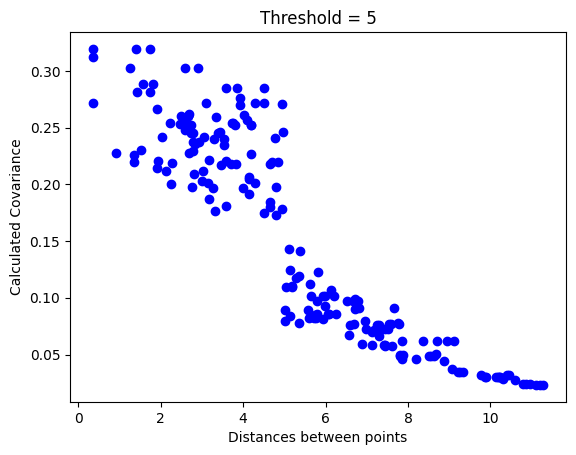

In [206]:
# plotting
plt.scatter(data['Distances'], data['Calculated Covariance'], c='blue')
# plt.yscale('log')
plt.ylabel('Calculated Covariance')
plt.xlabel('Distances between points')
plt.title('Threshold = ' + str(threshold))
plt.show()